#### KO example
Reproducing example of KO equation, with a dataset we created with the same times as the original

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

2023-03-22 18:42:20.232825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 18:42:20.986633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 18:42:20.986691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 18:42:21.181811: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 18:42:23.400596: W tensorflow/stream_executor/platform/de

In [2]:
def load_data():
    data = sio.loadmat("KO_train.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [2]:
def ode_fn(t, u, a, b):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]

    f1 = u1_t - a * u2 * u3
    f2 = u2_t - b * u1 * u3
    f3 = u3_t + (a + b) * u1 * u2
    return tf.concat([f1, f2, f3], axis=-1)

@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=666,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n" % (np.mean(results)))

    processes = [process_u, process_a, process_b]
    return processes, samples, model

def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]  # training data

    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )

#### Original dataset:

In [3]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

2023-03-22 15:29:18.639918: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-22 15:29:18.640008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilaria-UX310UQK): /proc/driver/nvidia/version does not exist
2023-03-22 15:29:18.641250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:29:18.645301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.317 

Execution time for 'Samplable' function is: 207.107 s, 3.452 mins


In [4]:
################################# Predictions ####################################
u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

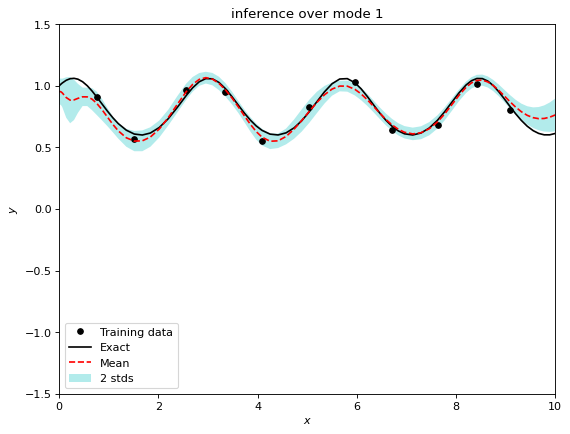

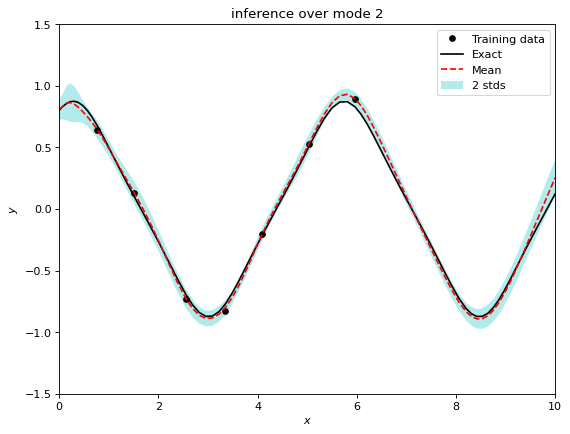

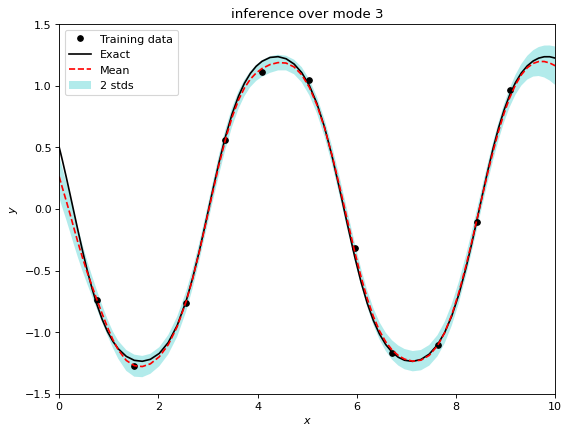

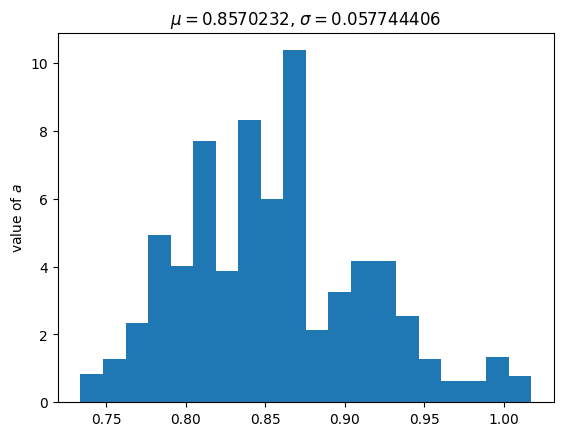

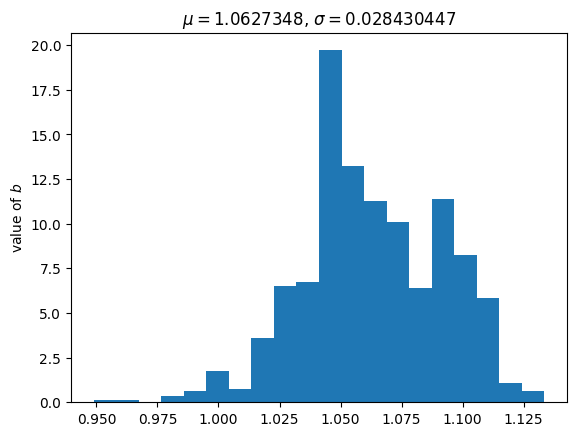

In [5]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)
neuq.utils.hist(a_pred.flatten(), name="value of $a$")
neuq.utils.hist(b_pred.flatten(), name="value of $b$")

#### New dataset:

In [3]:
def load_data():
    # data = sio.loadmat("KO_train.mat")
    data = sio.loadmat("KO_dataset.mat")
    t_test, u_test = data["t_test"], data["u_test_new"]
    t_u_train, u_train = data["t_u_train"], data["u_train_new"]
    t_f_train, f_train = data["t_f_train"], data["f_train_new"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [4]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

2023-03-22 18:42:28.337056: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-22 18:42:28.337137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilaria-UX310UQK): /proc/driver/nvidia/version does not exist
2023-03-22 18:42:28.340438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 18:42:28.365977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.472 

Execution time for 'Samplable' function is: 167.984 s, 2.800 mins


In [5]:
################################# Predictions ####################################
u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

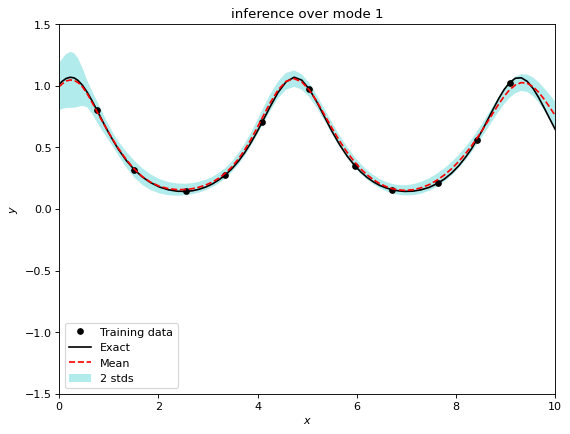

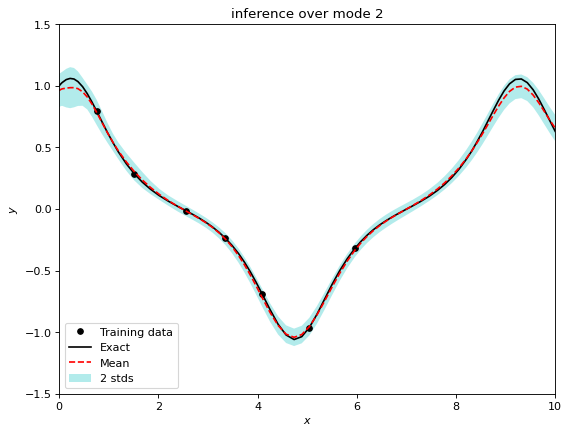

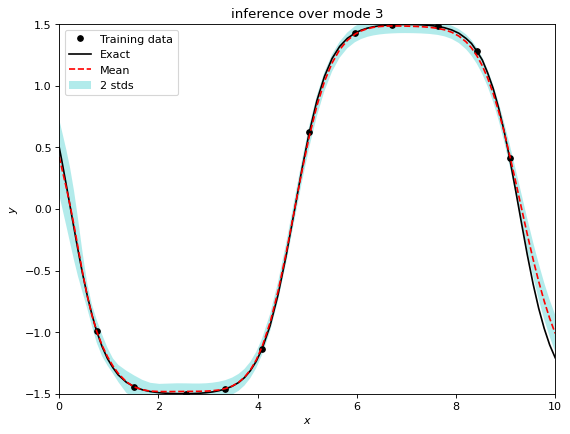

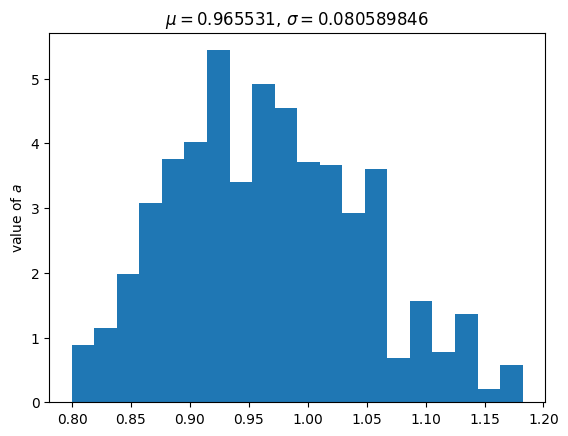

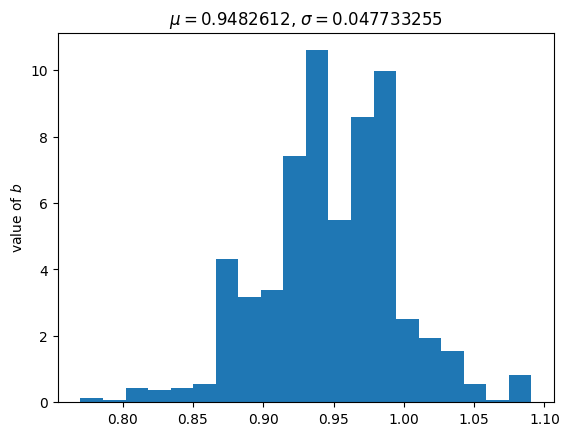

In [6]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)
neuq.utils.hist(a_pred.flatten(), name="value of $a$")
neuq.utils.hist(b_pred.flatten(), name="value of $b$")